In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Comparing Social Origins Model and Stochastic Block Model

In this Jupyter notebook, we delve into a comprehensive comparison between the Social Origins Model and the Stochastic Block Model. These two models are widely used in network analysis, but they are often applied to different scenarios and have distinct parameterizations, making direct comparisons challenging.

## Introduction

The primary aim of this notebook is to explore and contrast the Social Origins Model and the Stochastic Block Model in terms of a common consolidation and homophily measurement framework. We seek to bridge the gap between these models by introducing two key metrics: the Mutual Information Index ($MI$) and the Nominal Assortativity ($r$). These metrics will enable us to capture attribute correlation and homophily, respectively, facilitating meaningful comparisons.

### Mutual Information Index

The Mutual Information Index ($MI$) is a statistical measure that quantifies the degree of association or dependency between two random variables. In the context of our models,$MI$ helps us capture the attribute correlation parameter, allowing us to assess how well each model accounts for the interplay between attributes within the network. The formula for $MI$ between two variables $X$ and $Y$ is:

$$
MI(X, Y) = \sum_{x \in X}\sum_{y \in Y} P(x, y) \cdot \log\left(\frac{P(x, y)}{P(x)P(y)}\right)
$$

Here, $P(x, y)$ represents the joint probability distribution of $X$ and $Y$, while $P(x)$ and $P(y)$ are the marginal probability distributions of $X$ and $Y$, respectively.$MI$ measures the reduction in uncertainty about one variable when the other variable is known.

### Nominal Assortativity

Nominal Assortativity ($r$) is a concept used to quantify the level of homophily within a network. It assesses whether nodes with similar attributes tend to connect more frequently than nodes with dissimilar attributes. The formula for $r$ is:

$$
r = \frac{\sum_{ij}(e_{ij} - a_i \cdot a_j)}{\sum_{ij}(a_{ij} - a_i \cdot a_j)}
$$

Where:
- $e_{ij}$ represents the fraction of edges in the network that connect nodes with attribute values $i$ and $j$.
- $a_i$ and$a_j$ are the fractions of edges corresponding to nodes with attribute values $i$ and $j$ in the network.

A positive value of$r$ indicates that nodes with similar attributes tend to connect more often, implying homophily, while a negative value suggests heterophily.



In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import network_generation as homomul
import spread_simulation
import homophily_multi_attr_viz as viz
from tqdm.notebook import tqdm
from network_stats import homophily_measure, consolidation_measure
from network_stats import adjusted_consolidation_measure
from network_generation import consol_comp_pop_frac_tnsr
import math
import itertools

## Social Orignins Model 8 values in 2 Dimension

In [ ]:

experiment_settings = {
    'n_networks': 2,
    'n_initial_seeds': 5
    }

model_settings = {
    'N': 1600,
    'm': 5,
    'H': 8,
    'D': 2,
    'alpha': 1,
    'beta': 1,
    'complex_threshold': 0.18,
    'initial_seed_filter': lambda x: x.nodes,
    'model_type': 'social_origins_network'
}
alpha_settings = np.linspace(-1,3,10)
beta_settings = np.linspace(-1,3,10)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Attribute Correlation $\beta$: -1.00 / Homophily $\alpha$: -1.00 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\beta$: -1.00 / Homophily $\alpha$: -0.56 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\beta$: -1.00 / Homophily $\alpha$: -0.11 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\beta$: -1.00 / Homophily $\alpha$: 0.33 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\beta$: -1.00 / Homophily $\alpha$: 0.78 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\beta$: -1.00 / Homophily $\alpha$: 1.22 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\beta$: -1.00 / Homophily $\alpha$: 1.67 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\beta$: -1.00 / Homophily $\alpha$: 2.11 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\beta$: -1.00 / Homophily $\alpha$: 2.56 => avg = 0.31; global = 0.30; avg iter = 8.7
Attribute Correl

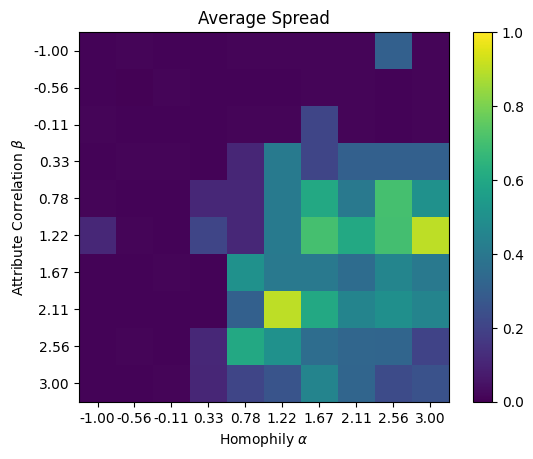

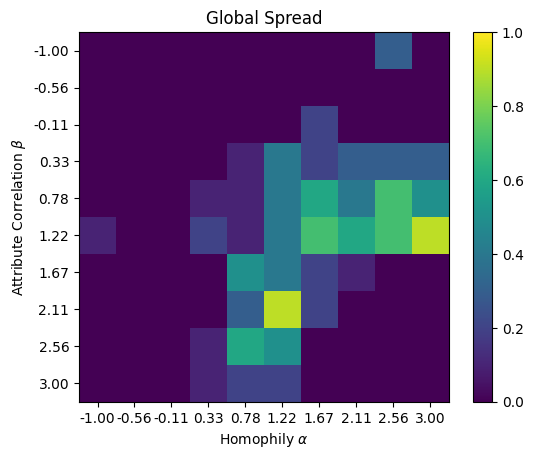

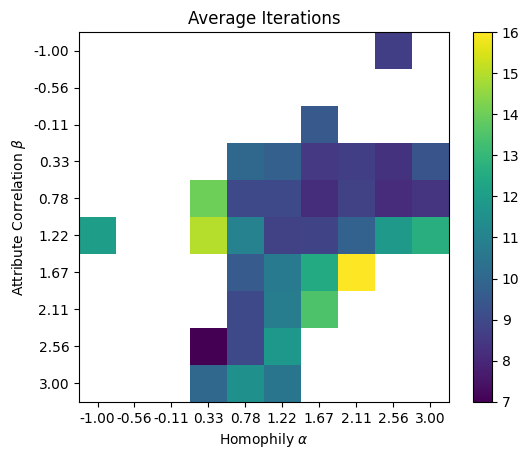

In [ ]:
_, r_so_8_2, _ = spread_simulation.setting_simulate('beta', beta_settings,
                                                          'alpha', alpha_settings,
                                                          model_settings, experiment_settings,
                                                          label1=r'Attribute Correlation $\beta$',
                                                          label2=r'Homophily $\alpha$')

In [ ]:
def attribute_dist(H = 2):
    max_dist = math.ceil(np.log2(H)) + 1
    def attributes_dist(a1, a2):
        for i in range(max_dist - 1, -1, -1):
            if a1//(2**i) != a2//(2**i):
                return i + 2
        return 1

    attribute_dist_matrix = np.zeros((H, H), dtype=np.int16)
    for i in range(H):
        for j in range(H):
            attribute_dist_matrix[i, j] = attributes_dist(i, j)
    return attribute_dist_matrix

def marginal_matrix(a,b, H = 2):
    D = 2

    max_dist = math.ceil(np.log2(H)) + 1
    attribute_dist_matrix = attribute_dist(H)

    marginal_matrix = np.zeros((H, H), dtype=np.float32)
    for d in range(max_dist):
        prob = np.exp(-b * d)
        for i in range(H):
            same_dist = []
            for j in range(H):
                if attribute_dist_matrix[i, j] == d + 1:
                   same_dist.append(j)
            for j in same_dist:
                marginal_matrix[i, j] = prob / len(same_dist)

    return marginal_matrix / marginal_matrix.max()

In [ ]:
def h_matrix(a, b, H=2, dimension_aggregation = np.min):
    D = 2

    node_dist_matrix = np.zeros((H**D, H**D), dtype=np.int16)

    max_dist = math.ceil(np.log2(H)) + 1
    attribute_dist_matrix = attribute_dist(H)
    mm = marginal_matrix(a, b, H=H)

    node_dist_matrix = np.zeros((H**D, H**D), dtype=np.float32)
    for i, n1 in enumerate(itertools.product(range(H), repeat=D)):
        for j, n2 in enumerate(itertools.product(range(H), repeat=D)):
            distances = [attribute_dist_matrix[n1[k], n2[k]]
                         for k in range(D)]
            node_dist_matrix[i, j] = dimension_aggregation(distances)

    h_matrix = np.zeros((H**D, H**D), dtype=np.float32)

    for d in range(max_dist):
        prob = np.exp(-a * d)
        for i, n1 in enumerate(itertools.product(range(H), repeat=D)):
            same_dist = []
            for j, n2 in enumerate(itertools.product(range(H), repeat=D)):
                if node_dist_matrix[i, j] == d + 1:
                   same_dist.append((j, mm[n2[0], n2[1]]))

            for j, n2 in same_dist:
                h_matrix[i, j] = prob / sum([mp for _, mp in same_dist])

    h_matrix = h_matrix + h_matrix.T
    return h_matrix / h_matrix.max()

In [ ]:
def appand_stats(results, hm, mm, s):
  h = homophily_measure(hm = hm)
  c = consolidation_measure(mm = mm)
  ac = adjusted_consolidation_measure(mm=mm)

  results['consolidation'].append(c)
  results['consolidation_adjusted'].append(ac)
  results['homophily_adjusted'].append(h)
  results['spread'].append(s)

  hm *= np.kron(mm, mm)
  h = homophily_measure(hm = hm)
  results['homophily'].append(h)
  return results

In [ ]:
results_so_8_2 = {
    'consolidation': [],
    'consolidation_adjusted': [],
    'homophily': [],
    'homophily_adjusted': [],
    'spread': []
}


for i, a in enumerate(alpha_settings):
  for j, b in enumerate(beta_settings):
    hm = h_matrix(a, b, H = 8)
    mm = marginal_matrix(a, b, H = 8)
    s = r_so_8_2[i,j]

    results_so_8_2 = appand_stats(results_so_8_2, hm, mm, s)


## SBM

In [ ]:
model_settings = {
    'N': 3200,
    'm': 5,
    'consolidation_param': 0.1,
    'marginal_distribution': [[0.5,0.5],[0.5,0.5]],
    'homophily': 0.8,
    'complex_threshold': 0.16,
    'initial_seed_filter': lambda x: x.nodes
}

  0%|          | 0/66 [00:00<?, ?it/s]

Attribute Correlation $\kappa$: 0.00 / Homophily $\lambda$: 0.00 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\kappa$: 0.00 / Homophily $\lambda$: 0.10 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\kappa$: 0.00 / Homophily $\lambda$: 0.20 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\kappa$: 0.00 / Homophily $\lambda$: 0.30 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\kappa$: 0.00 / Homophily $\lambda$: 0.40 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\kappa$: 0.00 / Homophily $\lambda$: 0.50 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\kappa$: 0.00 / Homophily $\lambda$: 0.60 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\kappa$: 0.00 / Homophily $\lambda$: 0.70 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\kappa$: 0.00 / Homophily $\lambda$: 0.80 => avg = 0.01; global = 0.00; avg iter = nan
Attribute 

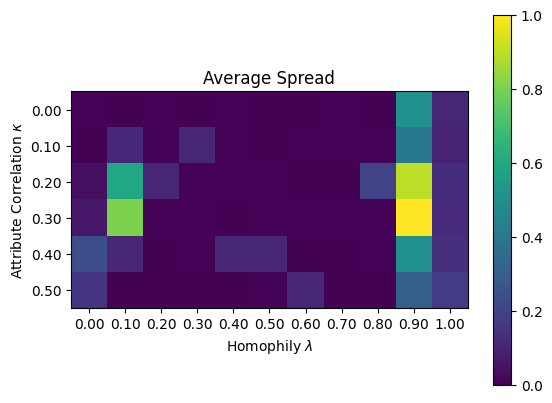

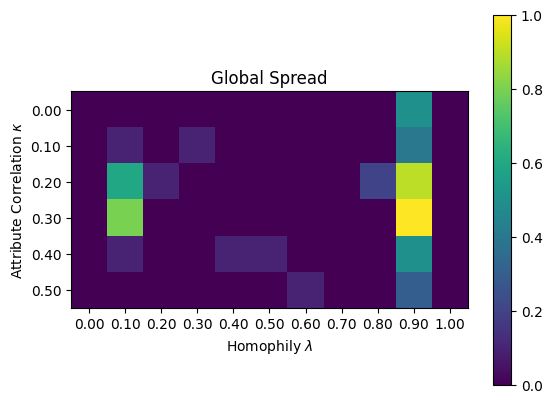

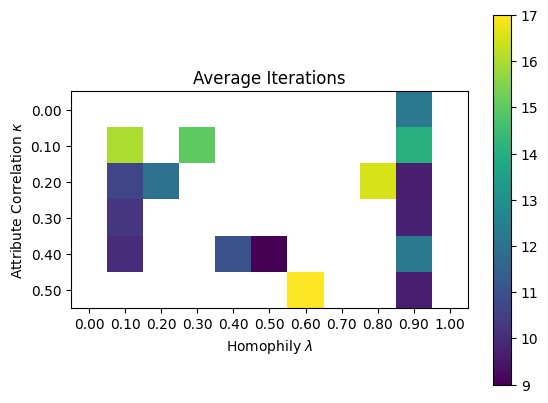

In [ ]:
homophily_settings = np.linspace(0,1,11)
consolidation_settings = np.linspace(0,0.5, 6)

_, r_sbm, _ = spread_simulation.setting_simulate('consolidation_param', consolidation_settings,
                                                             'homophily', homophily_settings,
                                                             model_settings, experiment_settings,
                                                             label1=r'Attribute Correlation $\kappa$',
                                                             label2=r'Homophily $\lambda$')


In [ ]:
results_sbm = {
    'consolidation': [],
    'consolidation_adjusted': [],
    'homophily': [],
    'homophily_adjusted': [],
    'spread': []
}

def hom_matrix(homophily):
  h1 = np.array([[homophily, 1-homophily], [1-homophily, homophily]])
  return np.kron(h1,h1)


In [ ]:
for i, c in enumerate(consolidation_settings):
  for j, h in enumerate(homophily_settings):
    hm = hom_matrix(h)
    mm = consol_comp_pop_frac_tnsr(model_settings['marginal_distribution'], c)
    s = r_sbm[i,j]

    results_sbm = appand_stats(results_sbm, hm, mm, s)

/content/network_stats.py:88: RuntimeWarning: invalid value encountered in divide
  hm = hm / hm.sum()


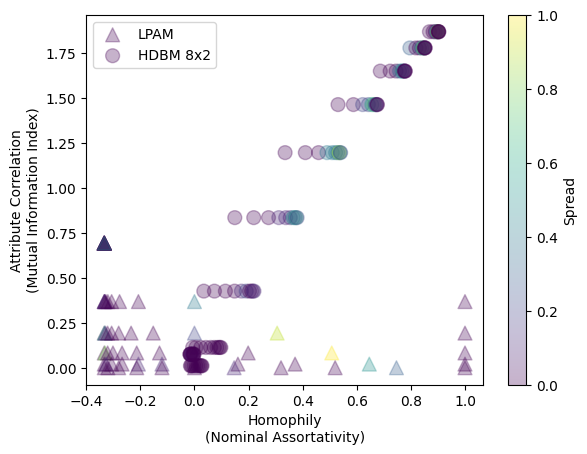

In [ ]:
# Create a scatter plot
plt.scatter(results_sbm['homophily'], results_sbm['consolidation'],
            c=results_sbm['spread'],
            cmap='viridis', s=100, alpha=0.3, marker='^',
            vmin=0, vmax=1,
            label='LPAM')

plt.scatter(results_so_8_2['homophily'], results_so_8_2['consolidation'],
            c=results_so_8_2['spread'],
            cmap='viridis', s=100, alpha=0.3,
            vmin=0, vmax=1,
            label='HDBM 8x2')

# Add labels and a colorbar
plt.xlabel('Homophily\n(Nominal Assortativity)')
plt.ylabel('Attribute Correlation\n(Mutual Information Index)')
plt.colorbar(label='Spread')
plt.legend()

# Show the plot
plt.show()

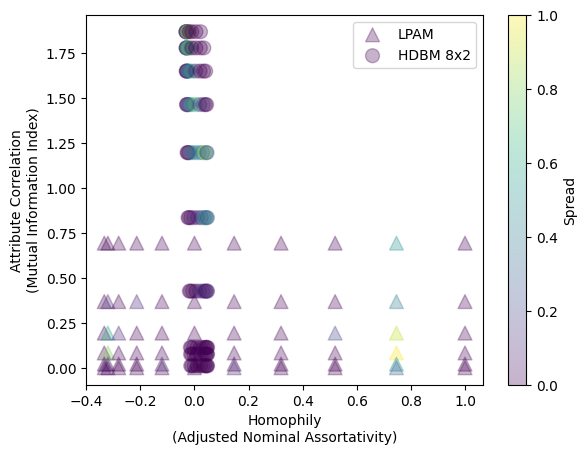

In [ ]:
# Create a scatter plot
plt.scatter(results_sbm['homophily_adjusted'], results_sbm['consolidation'],
            c=results_sbm['spread'],
            cmap='viridis', s=100, alpha=0.3, marker='^',
            vmin=0, vmax=1,
            label='LPAM')

plt.scatter(results_so_8_2['homophily_adjusted'], results_so_8_2['consolidation'],
            c=results_so_8_2['spread'],
            cmap='viridis', s=100, alpha=0.3,
            vmin=0, vmax=1,
            label='HDBM 8x2')


# Add labels and a colorbar
plt.xlabel('Homophily\n(Adjusted Nominal Assortativity)')
plt.ylabel('Attribute Correlation\n(Mutual Information Index)')
plt.colorbar(label='Spread')
plt.legend()


# Show the plot
plt.show()

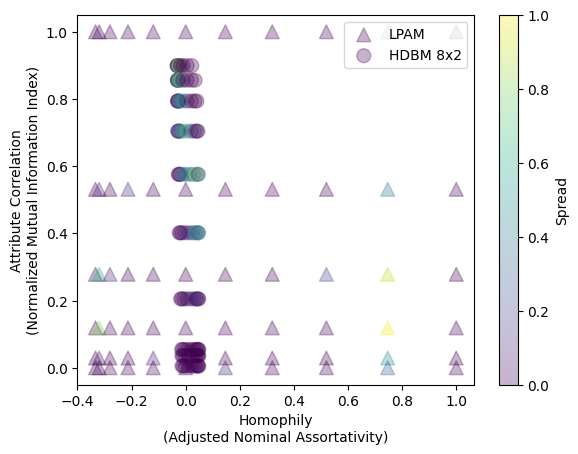

In [ ]:
# Create a scatter plot
plt.scatter(results_sbm['homophily_adjusted'], results_sbm['consolidation_adjusted'],
            c=results_sbm['spread'],
            cmap='viridis', s=100, alpha=0.3, marker='^',
            vmin=0, vmax=1,
            label='LPAM')

plt.scatter(results_so_8_2['homophily_adjusted'], results_so_8_2['consolidation_adjusted'],
            c=results_so_8_2['spread'],
            cmap='viridis', s=100, alpha=0.3,
            vmin=0, vmax=1,
            label='HDBM 8x2')


# Add labels and a colorbar
plt.xlabel('Homophily\n(Adjusted Nominal Assortativity)')
plt.ylabel('Attribute Correlation\n(Normalized Mutual Information Index)')
plt.colorbar(label='Spread')
plt.legend()


# Show the plot
plt.show()

## Social Orignin Model 2 values in 2 Dimension

  0%|          | 0/100 [00:00<?, ?it/s]

Attribute Correlation $\beta$: -1.00 / Homophily $\alpha$: -1.00 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\beta$: -1.00 / Homophily $\alpha$: -0.56 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\beta$: -1.00 / Homophily $\alpha$: -0.11 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\beta$: -1.00 / Homophily $\alpha$: 0.33 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\beta$: -1.00 / Homophily $\alpha$: 0.78 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\beta$: -1.00 / Homophily $\alpha$: 1.22 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\beta$: -1.00 / Homophily $\alpha$: 1.67 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\beta$: -1.00 / Homophily $\alpha$: 2.11 => avg = 0.01; global = 0.00; avg iter = nan
Attribute Correlation $\beta$: -1.00 / Homophily $\alpha$: 2.56 => avg = 0.02; global = 0.00; avg iter = nan
Attribute Correl

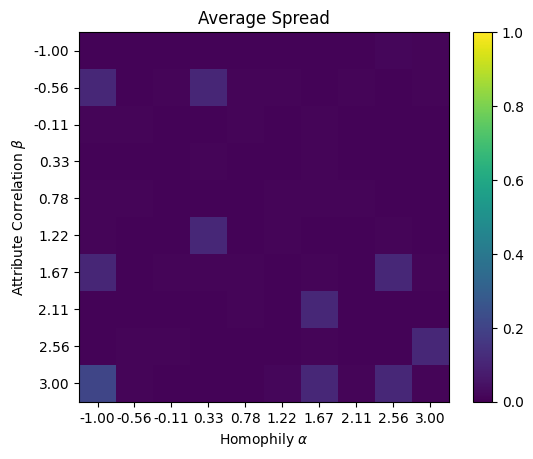

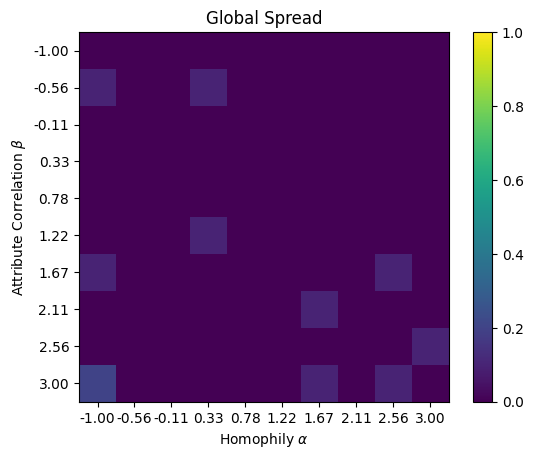

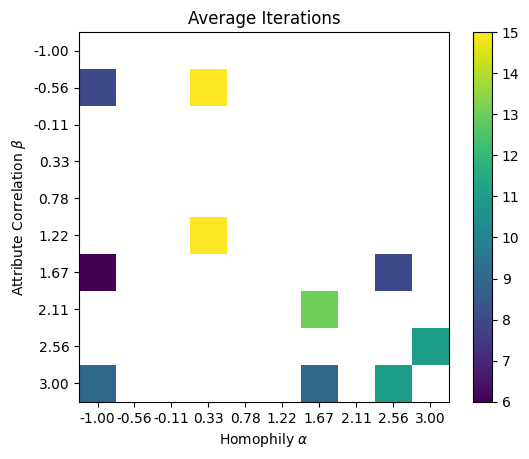

In [24]:
model_settings = {
    'N': 1600,
    'm': 5,
    'H': 2,
    'D': 2,
    'alpha': 1,
    'beta': 1,
    'complex_threshold': 0.18,
    'initial_seed_filter': lambda x: x.nodes,
    'model_type': 'social_origins_network'
}

_, r_so_2_2, _ = spread_simulation.setting_simulate('beta', beta_settings,
                                                          'alpha', alpha_settings,
                                                          model_settings, experiment_settings,
                                                          label1=r'Attribute Correlation $\beta$',
                                                          label2=r'Homophily $\alpha$')

In [25]:
results_so_2_2 = {
    'consolidation': [],
    'consolidation_adjusted': [],
    'homophily': [],
    'homophily_adjusted': [],
    'spread': []
}

for i, a in enumerate(alpha_settings):
  for j, b in enumerate(beta_settings):
    hm = h_matrix(a, b, H = 2)
    mm = marginal_matrix(a, b, H = 2)
    s = r_so_2_2[i,j]

    results_so_2_2 = appand_stats(results_so_2_2, hm, mm, s)





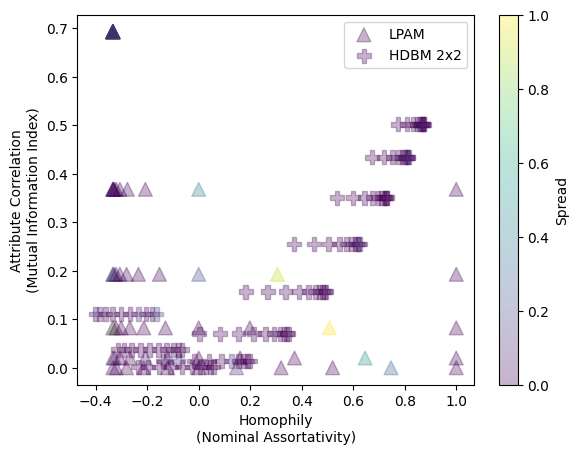

In [26]:
# Create a scatter plot
plt.scatter(results_sbm['homophily'], results_sbm['consolidation'],
            c=results_sbm['spread'],
            cmap='viridis', s=100, alpha=0.3, marker='^',
            vmin=0, vmax=1,
            label='LPAM')

plt.scatter(results_so_2_2['homophily'], results_so_2_2['consolidation'],
            c=results_so_2_2['spread'],
            cmap='viridis', s=100, alpha=0.3, marker='P',
            vmin=0, vmax=1,
            label='HDBM 2x2')

# Add labels and a colorbar
plt.xlabel('Homophily\n(Nominal Assortativity)')
plt.ylabel('Attribute Correlation\n(Mutual Information Index)')
plt.colorbar(label='Spread')
plt.legend()

# Show the plot
plt.show()

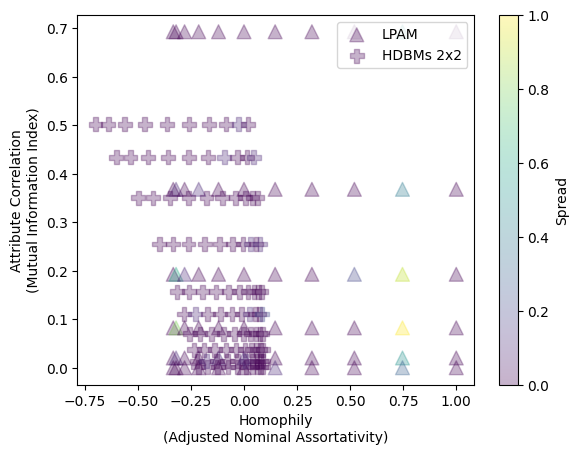

In [27]:
# Create a scatter plot
plt.scatter(results_sbm['homophily_adjusted'], results_sbm['consolidation'],
            c=results_sbm['spread'],
            cmap='viridis', s=100, alpha=0.3, marker='^',
            vmin=0, vmax=1,
            label='LPAM')

plt.scatter(results_so_2_2['homophily_adjusted'], results_so_2_2['consolidation'],
            c=results_so_2_2['spread'],
            cmap='viridis', s=100, alpha=0.3, marker='P',
            vmin=0, vmax=1,
            label='HDBMs 2x2')

# Add labels and a colorbar
plt.xlabel('Homophily\n(Adjusted Nominal Assortativity)')
plt.ylabel('Attribute Correlation\n(Mutual Information Index)')
plt.colorbar(label='Spread')
plt.legend()

# Show the plot
plt.show()

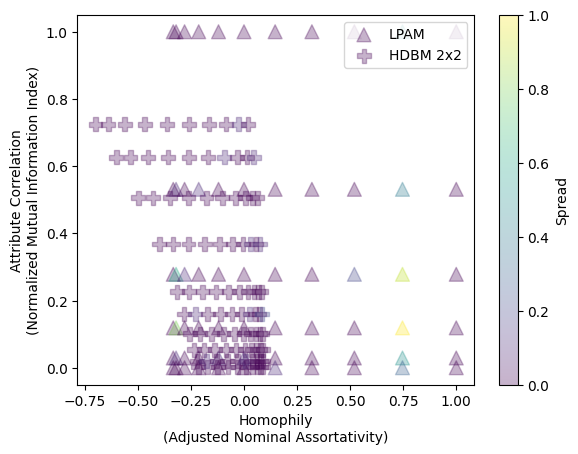

In [28]:
# Create a scatter plot
plt.scatter(results_sbm['homophily_adjusted'], results_sbm['consolidation_adjusted'],
            c=results_sbm['spread'],
            cmap='viridis', s=100, alpha=0.3, marker='^',
            vmin=0, vmax=1,
            label='LPAM')

plt.scatter(results_so_2_2['homophily_adjusted'], results_so_2_2['consolidation_adjusted'],
            c=results_so_2_2['spread'],
            cmap='viridis', s=100, alpha=0.3, marker='P',
            vmin=0, vmax=1,
            label='HDBM 2x2')


# Add labels and a colorbar
plt.xlabel('Homophily\n(Adjusted Nominal Assortativity)')
plt.ylabel('Attribute Correlation\n(Normalized Mutual Information Index)')
plt.colorbar(label='Spread')
plt.legend()


# Show the plot
plt.show()

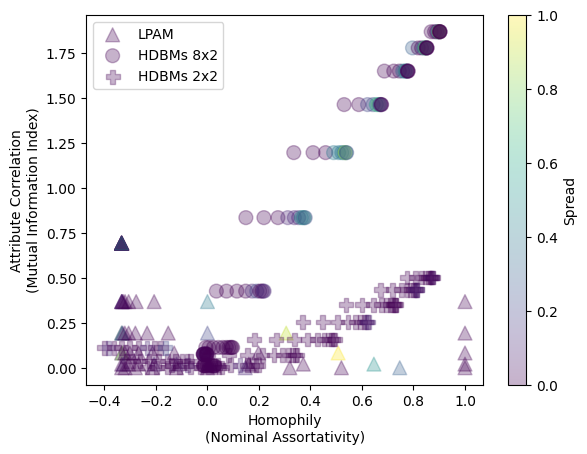

In [29]:
# Create a scatter plot
plt.scatter(results_sbm['homophily'], results_sbm['consolidation'],
            c=results_sbm['spread'],
            cmap='viridis', s=100, alpha=0.3, marker='^',
            vmin=0, vmax=1,
            label='LPAM')

# Create a scatter plot
plt.scatter(results_so_8_2['homophily'], results_so_8_2['consolidation'],
            c=results_so_8_2['spread'],
            cmap='viridis', s=100, alpha=0.3,
            vmin=0, vmax=1,
            label='HDBMs 8x2')

plt.scatter(results_so_2_2['homophily'], results_so_2_2['consolidation'],
            c=results_so_2_2['spread'],
            cmap='viridis', s=100, alpha=0.3, marker='P',
            vmin=0, vmax=1,
            label='HDBMs 2x2')

# Add labels and a colorbar
plt.xlabel('Homophily\n(Nominal Assortativity)')
plt.ylabel('Attribute Correlation\n(Mutual Information Index)')
plt.colorbar(label='Spread')
plt.legend()

# Show the plot
plt.show()

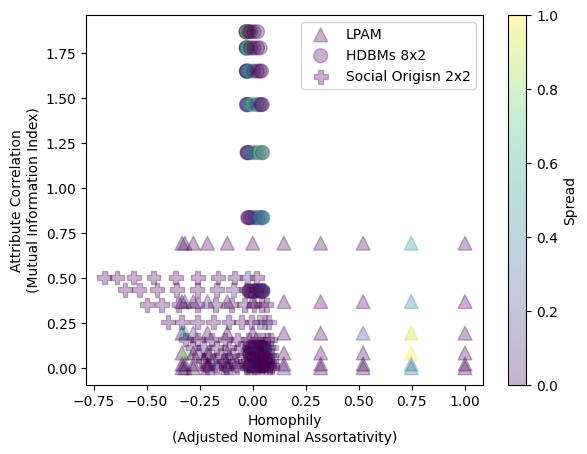

In [30]:
# Create a scatter plot
plt.scatter(results_sbm['homophily_adjusted'], results_sbm['consolidation'],
            c=results_sbm['spread'],
            cmap='viridis', s=100, alpha=0.3, marker='^',
            vmin=0, vmax=1,
            label='LPAM')

# Create a scatter plot
plt.scatter(results_so_8_2['homophily_adjusted'], results_so_8_2['consolidation'],
            c=results_so_8_2['spread'],
            cmap='viridis', s=100, alpha=0.3,
            vmin=0, vmax=1,
            label='HDBMs 8x2')

plt.scatter(results_so_2_2['homophily_adjusted'], results_so_2_2['consolidation'],
            c=results_so_2_2['spread'],
            cmap='viridis', s=100, alpha=0.3, marker='P',
            vmin=0, vmax=1,
            label='Social Origisn 2x2')

# Add labels and a colorbar
plt.xlabel('Homophily\n(Adjusted Nominal Assortativity)')
plt.ylabel('Attribute Correlation\n(Mutual Information Index)')
plt.colorbar(label='Spread')
plt.legend()

# Show the plot
plt.show()

## Parameters vs Setting

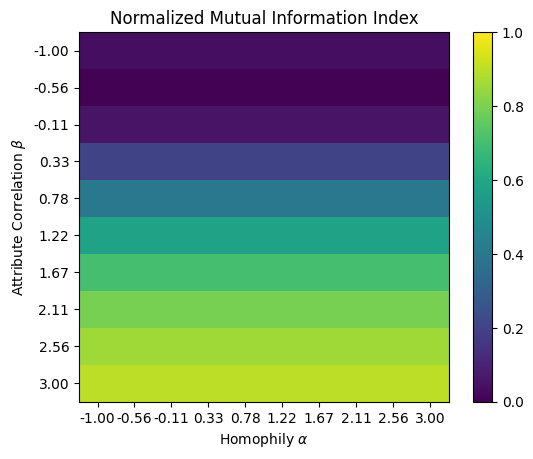

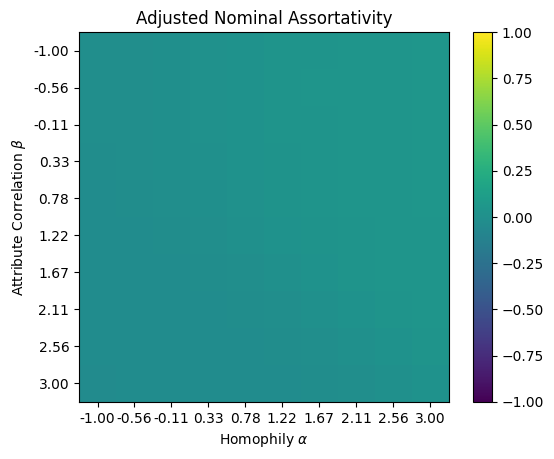

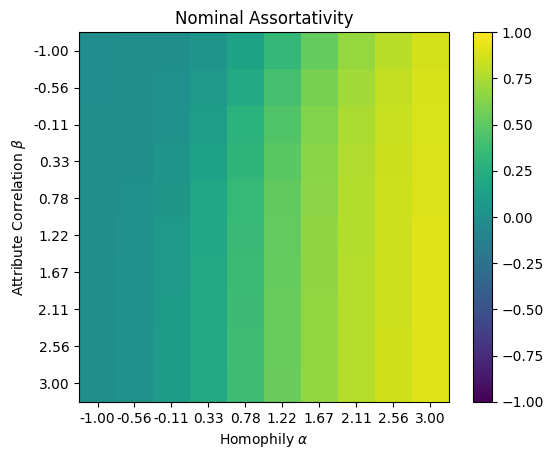

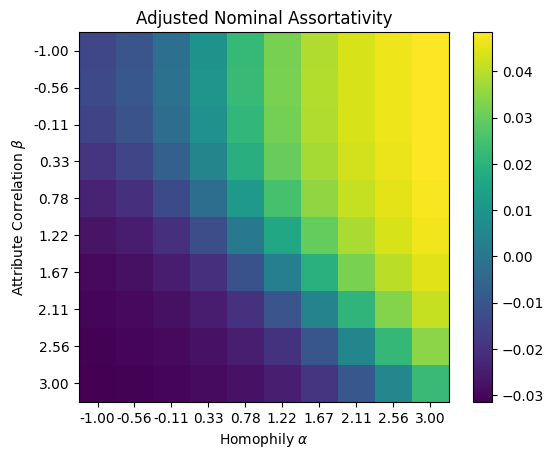

In [ ]:
import homophily_multi_attr_viz as viz

adj_consolidation_result = np.zeros((alpha_settings.size,beta_settings.size))
adj_homophily_result = np.zeros((alpha_settings.size,beta_settings.size))
homophily_result =  np.zeros((alpha_settings.size,beta_settings.size))


for i, a in enumerate(alpha_settings):
  for j, b in enumerate(beta_settings):
    hm = h_matrix(a, b, H = 8)
    mm = marginal_matrix(a, b, H = 8)
    adj_consolidation_result[j,i] = adjusted_consolidation_measure(mm=mm)
    adj_homophily_result[j, i] =  homophily_measure(hm = hm)

    hm *= np.kron(mm, mm)
    homophily_result[i, j] = homophily_measure(hm = hm)

viz.fig_2attr_heatmap(r'Attribute Correlation $\beta$', beta_settings,
                       r'Homophily $\alpha$', alpha_settings,
                      adj_consolidation_result, title='Normalized Mutual Information Index')

viz.fig_2attr_heatmap(r'Attribute Correlation $\beta$', beta_settings,
                       r'Homophily $\alpha$', alpha_settings,
                      adj_homophily_result, title='Adjusted Nominal Assortativity',
                      clim=(-1,1))

viz.fig_2attr_heatmap(r'Attribute Correlation $\beta$', beta_settings,
                       r'Homophily $\alpha$', alpha_settings,
                      homophily_result, title='Nominal Assortativity',
                      clim=(-1,1))

viz.fig_2attr_heatmap(r'Attribute Correlation $\beta$', beta_settings,
                       r'Homophily $\alpha$', alpha_settings,
                      adj_homophily_result, title='Adjusted Nominal Assortativity',
                      clim=None)

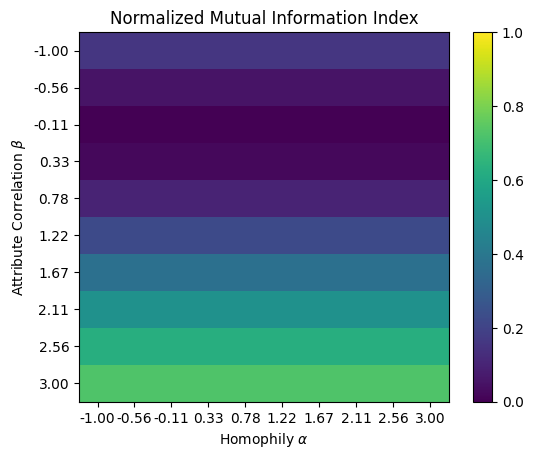

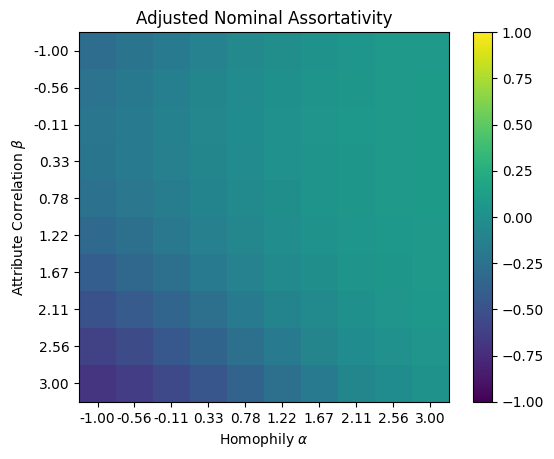

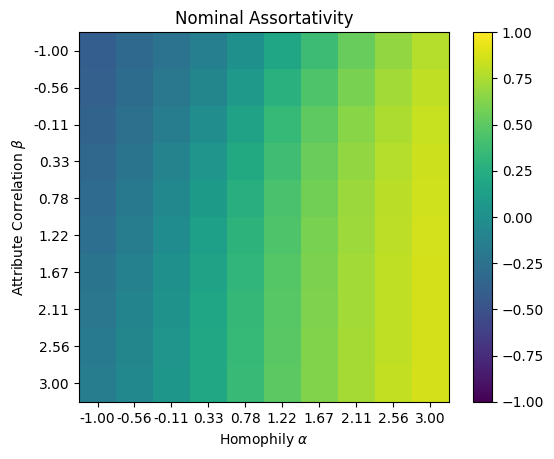

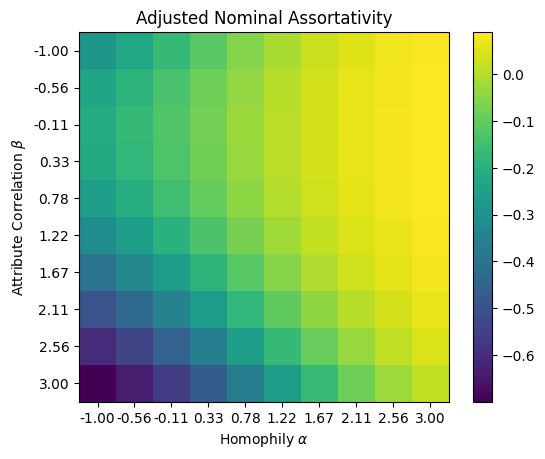

In [ ]:
adj_consolidation_result = np.zeros((alpha_settings.size,beta_settings.size))
adj_homophily_result = np.zeros((alpha_settings.size,beta_settings.size))
homophily_result =  np.zeros((alpha_settings.size,beta_settings.size))


for i, a in enumerate(alpha_settings):
  for j, b in enumerate(beta_settings):
    hm = h_matrix(a, b, H = 2)
    mm = marginal_matrix(a, b, H = 2)
    adj_consolidation_result[j,i] = adjusted_consolidation_measure(mm=mm)
    adj_homophily_result[j, i] =  homophily_measure(hm = hm)

    hm *= np.kron(mm, mm)
    homophily_result[i, j] = homophily_measure(hm = hm)


viz.fig_2attr_heatmap(r'Attribute Correlation $\beta$', beta_settings,
                       r'Homophily $\alpha$', alpha_settings,
                      adj_consolidation_result, title='Normalized Mutual Information Index')

viz.fig_2attr_heatmap(r'Attribute Correlation $\beta$', beta_settings,
                       r'Homophily $\alpha$', alpha_settings,
                      adj_homophily_result, title='Adjusted Nominal Assortativity',
                      clim=(-1,1))

viz.fig_2attr_heatmap(r'Attribute Correlation $\beta$', beta_settings,
                       r'Homophily $\alpha$', alpha_settings,
                      homophily_result, title='Nominal Assortativity',
                      clim=(-1,1))

viz.fig_2attr_heatmap(r'Attribute Correlation $\beta$', beta_settings,
                       r'Homophily $\alpha$', alpha_settings,
                      adj_homophily_result, title='Adjusted Nominal Assortativity',
                      clim=None)

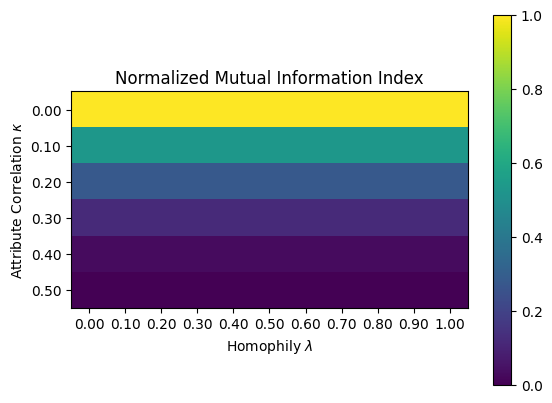

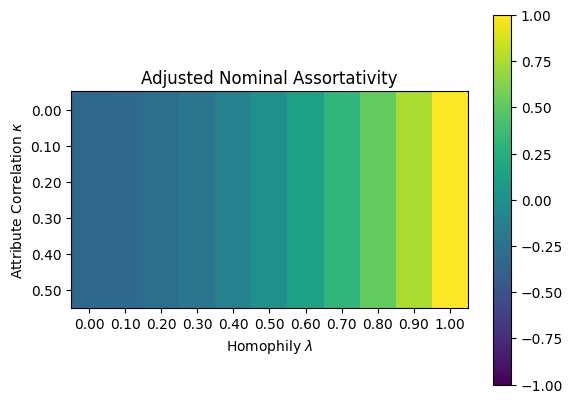

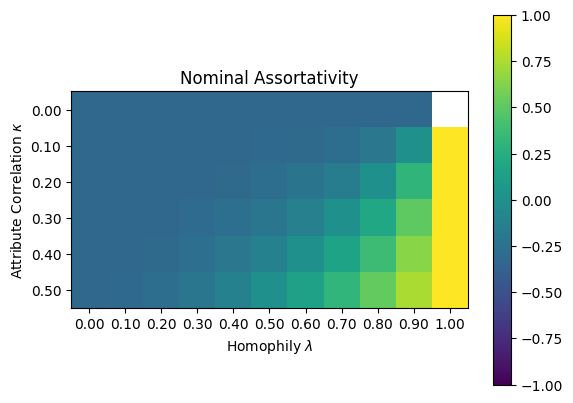

In [ ]:
model_settings = {
    'N': 3200,
    'm': 5,
    'consolidation_param': 0.1,
    'marginal_distribution': [[0.5,0.5],[0.5,0.5]],
    'homophily': 0.8,
    'complex_threshold': 0.16,
    'initial_seed_filter': lambda x: x.nodes
}

homophily_settings = np.linspace(0,1,11)
consolidation_settings = np.linspace(0,0.5, 6)

consolidation_result = np.zeros((consolidation_settings.size,homophily_settings.size))
adj_homophily_result = np.zeros((consolidation_settings.size,homophily_settings.size))
homophily_result =  np.zeros((consolidation_settings.size,homophily_settings.size))

for i, c in enumerate(consolidation_settings):
  for j, h in enumerate(homophily_settings):
    hm = hom_matrix(h)
    mm = consol_comp_pop_frac_tnsr(model_settings['marginal_distribution'], c)

    consolidation_result[i,j] = adjusted_consolidation_measure(mm=mm)
    adj_homophily_result[i,j] =  homophily_measure(hm = hm)

    hm *= np.kron(mm, mm)
    homophily_result[i, j] = homophily_measure(hm = hm)

viz.fig_2attr_heatmap(r'Attribute Correlation $\kappa$', consolidation_settings,
                       r'Homophily $\lambda$', homophily_settings,
                      consolidation_result, title='Normalized Mutual Information Index')

viz.fig_2attr_heatmap(r'Attribute Correlation $\kappa$', consolidation_settings,
                       r'Homophily $\lambda$', homophily_settings,
                      adj_homophily_result, title='Adjusted Nominal Assortativity',
                      clim=(-1,1))

viz.fig_2attr_heatmap(r'Attribute Correlation $\kappa$', consolidation_settings,
                       r'Homophily $\lambda$', homophily_settings,
                      homophily_result, title='Nominal Assortativity',
                      clim=(-1,1))